In [1]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tatiana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tatiana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# используем ту же функцию, что и в первом задании
def scrape_bbc_news(category, num_articles=5):
    """
    Собирает указанное количество свежих новостей из указанной категории BBC News.
    Возвращает список словарей с текстом новости и URL.
    """
    category_urls = {
        'business': 'https://www.bbc.com/news/business',
        'entertainment': 'https://www.bbc.com/news/entertainment_and_arts',
        'politics': 'https://www.bbc.com/news/politics',
        'sport': 'https://www.bbc.com/sport',
        'tech': 'https://www.bbc.com/news/technology'
    }

    if category not in category_urls:
        print(f"Ошибка: Категория '{category}' не найдена в списке URL.")
        return []

    category_url = category_urls[category]

    try:
        response = requests.get(category_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        articles = []
        count = 0

        # Находим все ссылки на статьи
        links = []
        if category != 'sport':
            links = soup.find_all('a', class_='sc-2e6baa30-0 gILusN')  # Используем класс ссылки для других категорий
        else:
            # Если это категория "sport", используем новый селектор
            links = soup.find_all('a', class_='ssrcss-1oo1bfh-PromoLink exn3ah95')


        for link in links:
            href = link['href']

            # Проверяем, является ли ссылка относительной или абсолютной
            if href.startswith('/news/'):  # Проверяем, начинается ли с '/news/'
                article_url = "https://www.bbc.com" + href
            elif href.startswith('/sport/'):  # Проверяем, начинается ли с '/sport/' (для спорта)
                article_url = "https://www.bbc.com" + href
            elif href.startswith('https://www.bbc.com/'):  # Проверяем, начинается ли с 'https://www.bbc.com/'
                article_url = href
            else:
                # Если это не ссылка на статью, пропускаем ее
                print(f"Пропущена ссылка (не статья): {href}")
                continue

            # Дополнительная проверка, чтобы убедиться, что это ссылка на статью
            if not re.search(r'/(news|sport)/\w+', article_url):  # Используем регулярное выражение
                print(f"Пропущена ссылка (не статья, не соответствует шаблону): {article_url}")
                continue

            try:
                article_response = requests.get(article_url)
                article_response.raise_for_status()
                article_soup = BeautifulSoup(article_response.content, 'html.parser')
                article_text = ''

                # Попытка 1: Извлечение текста из div с data-component="text-block"
                text_block = article_soup.find('div', {'data-component': 'text-block'})
                if text_block:
                    for p in text_block.find_all('p'):
                        article_text += p.text + '\n'

                # Попытка 2: Если не найдено, извлечение текста из div с class="article__body"
                if not article_text:
                    article_body = article_soup.find('div', class_='article__body')
                    if article_body:
                        for p in article_body.find_all('p'):
                            article_text += p.text + '\n'

                # Попытка 3: Если не найдено и это страница спорта, ищем div с class="ssrcss-11r1m41-RichTextComponentWrapper e24u68q0"
                if category == 'sport' and not article_text:
                    sport_text_wrapper = article_soup.find('div', class_='ssrcss-11r1m41-RichTextComponentWrapper e24u68q0')
                    if sport_text_wrapper:
                        for p in sport_text_wrapper.find_all('p'):
                            article_text += p.text + '\n'

                if article_text:
                    articles.append({'text': article_text, 'url': article_url})
                    count += 1
                else:
                    print(f"Предупреждение: Пустой текст статьи с URL: {article_url}")

            except requests.exceptions.RequestException as e:
                print(f"Ошибка при запросе статьи {article_url}: {e}")

            if count >= num_articles:
                break

        return articles

    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе категории {category_url}: {e}")
        return []

In [5]:
def preprocess_text(text):
    """Предобработка текста: удаление шума, стоп-слов, лемматизация."""
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    stop_words = stopwords.words('english')
    text = [word for word in text.split() if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = ' '.join(text)
    return text

In [7]:
def display_topics(model, feature_names, num_top_words=10):
    """Функция для отображения наиболее важных слов для каждой темы."""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [15]:
def visualize_topic_distribution(topic_distributions, categories, feature_names_dict, lda_models, num_top_words=5):
    """Визуализация распределения тем по категориям."""
    num_categories = len(categories)

    fig, axes = plt.subplots(num_categories, 1, figsize=(12, 6 * num_categories)) # Increased figure size

    for i, category in enumerate(categories):
        topic_distribution = np.mean(topic_distributions[category], axis=0) # Mean topic distribution for the category
        num_topics = lda_models[category].n_components # Get the number of topics

        axes[i].bar(range(num_topics), topic_distribution)
        axes[i].set_xlabel("Тема")
        axes[i].set_ylabel("Доля")
        axes[i].set_title(f"Распределение тем в категории: {category}")
        axes[i].set_xticks(range(num_topics))
        axes[i].set_xticklabels([f"Тема {j+1}" for j in range(num_topics)], rotation=45, ha="right") # Rotate x-axis labels
        axes[i].set_ylim(0, max(topic_distribution) * 1.2) # Adjust y-axis limit

        # Сохраните названия функций и модель LDA
        top_words = []
        for topic_idx in range(num_topics):
            topic = lda_models[category].components_[topic_idx]
            top_word_indices = topic.argsort()[:-num_top_words - 1:-1]

            # Truncate top_word_indices if it exceeds the size of feature_names
            top_word_indices = top_word_indices[top_word_indices < len(feature_names_dict[category])]

            # Check if top_word_indices is empty after filtering
            if len(top_word_indices) > 0:
                top_words_for_topic = [feature_names_dict[category][idx] for idx in top_word_indices]
            else:
                top_words_for_topic = ["No words"] # Handle the case where there are no top words

            # Join top words with newline character for multiline labels
            top_words.append("\n".join(top_words_for_topic))

        # Annotate each graph with top words for each topic
        for j, topic_idx in enumerate(range(num_topics)):
            axes[i].text(topic_idx, 0, top_words[topic_idx], ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()
        

Анализ категории: business
Пропущена ссылка (не статья): /
Пропущена ссылка (не статья): /
Пропущена ссылка (не статья): /sport
Пропущена ссылка (не статья): /video
Пропущена ссылка (не статья, не соответствует шаблону): https://www.bbc.com/weather
Пропущена ссылка (не статья, не соответствует шаблону): https://www.bbc.com/newsletters
Пропущена ссылка (не статья): https://cloud.email.bbc.com/WorldofBusiness_Newsletter_Signup?&at_bbc_team=studios&at_medium=emails&at_objective=acquisition&at_ptr_type=&at_ptr_name=bbc.com&at_format=Module&at_link_origin=homepage&at_campaign=wob&at_campaign_type=owned
Пропущена ссылка (не статья): https://cloud.email.bbc.com/WorldofBusiness_Newsletter_Signup?&at_bbc_team=studios&at_medium=emails&at_objective=acquisition&at_ptr_type=&at_ptr_name=bbc.com&at_format=Module&at_link_origin=homepage&at_campaign=wob&at_campaign_type=owned
Пропущена ссылка (не статья, не соответствует шаблону): https://www.bbc.com/audio/category/business
Пропущена ссылка (не статья

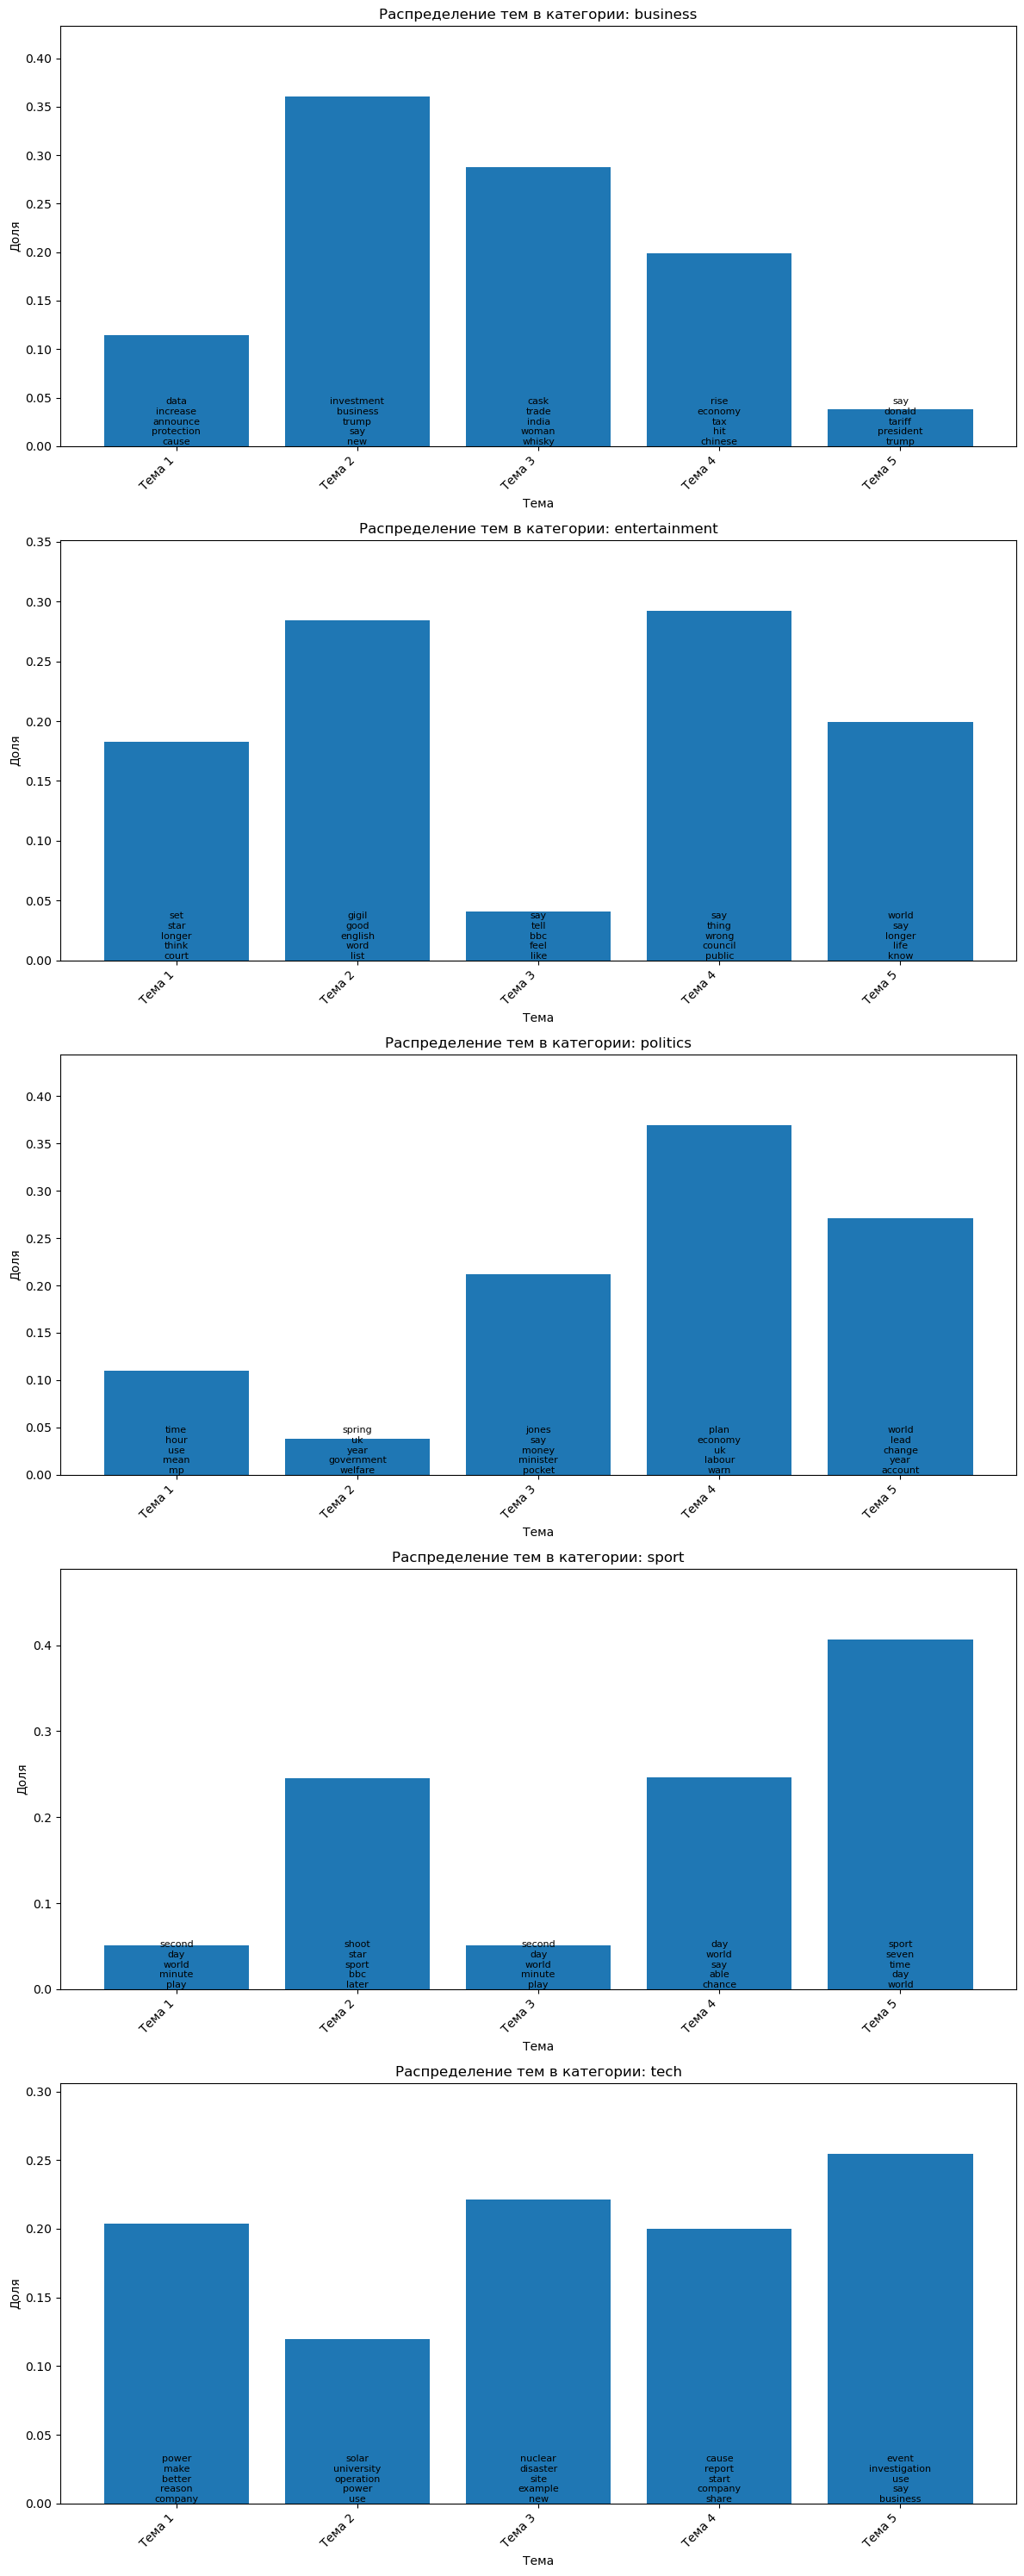

In [17]:
# Основные параметры
num_topics = 5
num_top_words = 10 # This is now just used for display_topics function
num_articles_per_category = 10

# Категории новостей
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Словари для хранения распределений тем и моделей LDA
topic_distributions = {}
lda_models = {}
feature_names_dict = {} # Dictionary to store feature names for each category

# Скрапинг, предобработка и моделирование тем для каждой категории
for category in categories:
    print(f"Анализ категории: {category}")

    # Скрапинг новостей
    articles = scrape_bbc_news(category, num_articles_per_category)
    if not articles:
        print(f"Не удалось получить новости для категории {category}")
        continue

    # Предобработка текстов
    texts = [preprocess_text(article['text']) for article in articles]

    # Создание матрицы Document-Term
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(texts)

    # Обучение модели LDA
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)

    # Сохраняем названия функций и модель LDA
    feature_names_dict[category] = vectorizer.get_feature_names_out()
    lda_models[category] = lda_model

    # Сохраняем распределение тем для каждой категории
    topic_distributions[category] = lda_model.transform(dtm)

    print("-" * 50)

# Визуализация распределения тем по категориям
visualize_topic_distribution(topic_distributions, categories, feature_names_dict, lda_models, num_top_words=5)

In [ ]:
"""
Таким образом, в категории business наиболее популярные темы: инвестиции, бизнес, Трамп(превосходство), сообщать, новости, торговля, Индия, 
женщина,бочка, виски
В категории entertainmentчаще наиболее распространенные топики:английский, неправильный, совет,слова, хороший, список(арена), 
крик (моды), мир     
В политике самые популярные темы о планировании, экономике, Великобритании, труде, потеплении, лидерах, изменениях
В категории sport - о времени, сроках, семи, днях, шансах, возможностях,мире, стрельбе, звездах 
В категории tech больше всего говорится об исследованиях, событиях, бизнесе, компаниях. ядерной катастрофе, новостнях, сайтах, 
университетах, операциях, отчетах, стартах, использовании, солнечной энергии
"""